# Demo of PyMC models

In [15]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm

In [16]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
export_images = True

## Synthetic Control

In [5]:
from causalpy.simulate_data import generate_synthetic_control_data

treatment_time = 70
data, weightings_true = generate_synthetic_control_data(treatment_time=treatment_time)
data.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,-1.632767,1.490882,0.359784,0.546869,0.293130,1.066574,-1.308567,0.472670,-0.0,0.438947
1,-1.579568,1.779866,0.972102,1.378298,-0.791247,0.861840,-0.646612,0.617062,-0.0,0.788911
2,-1.071887,0.761845,0.888507,1.957141,-0.084943,0.941387,0.411282,0.763621,-0.0,0.817995
3,-1.256297,1.641365,1.560311,2.515862,0.056269,0.992914,1.167966,0.913512,-0.0,0.567297
4,-0.957848,1.505170,2.003649,2.800272,0.036271,0.876098,1.897527,1.067104,-0.0,1.075895


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.9013, but should be close to 0.8. Try to increase the number of tuning steps.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


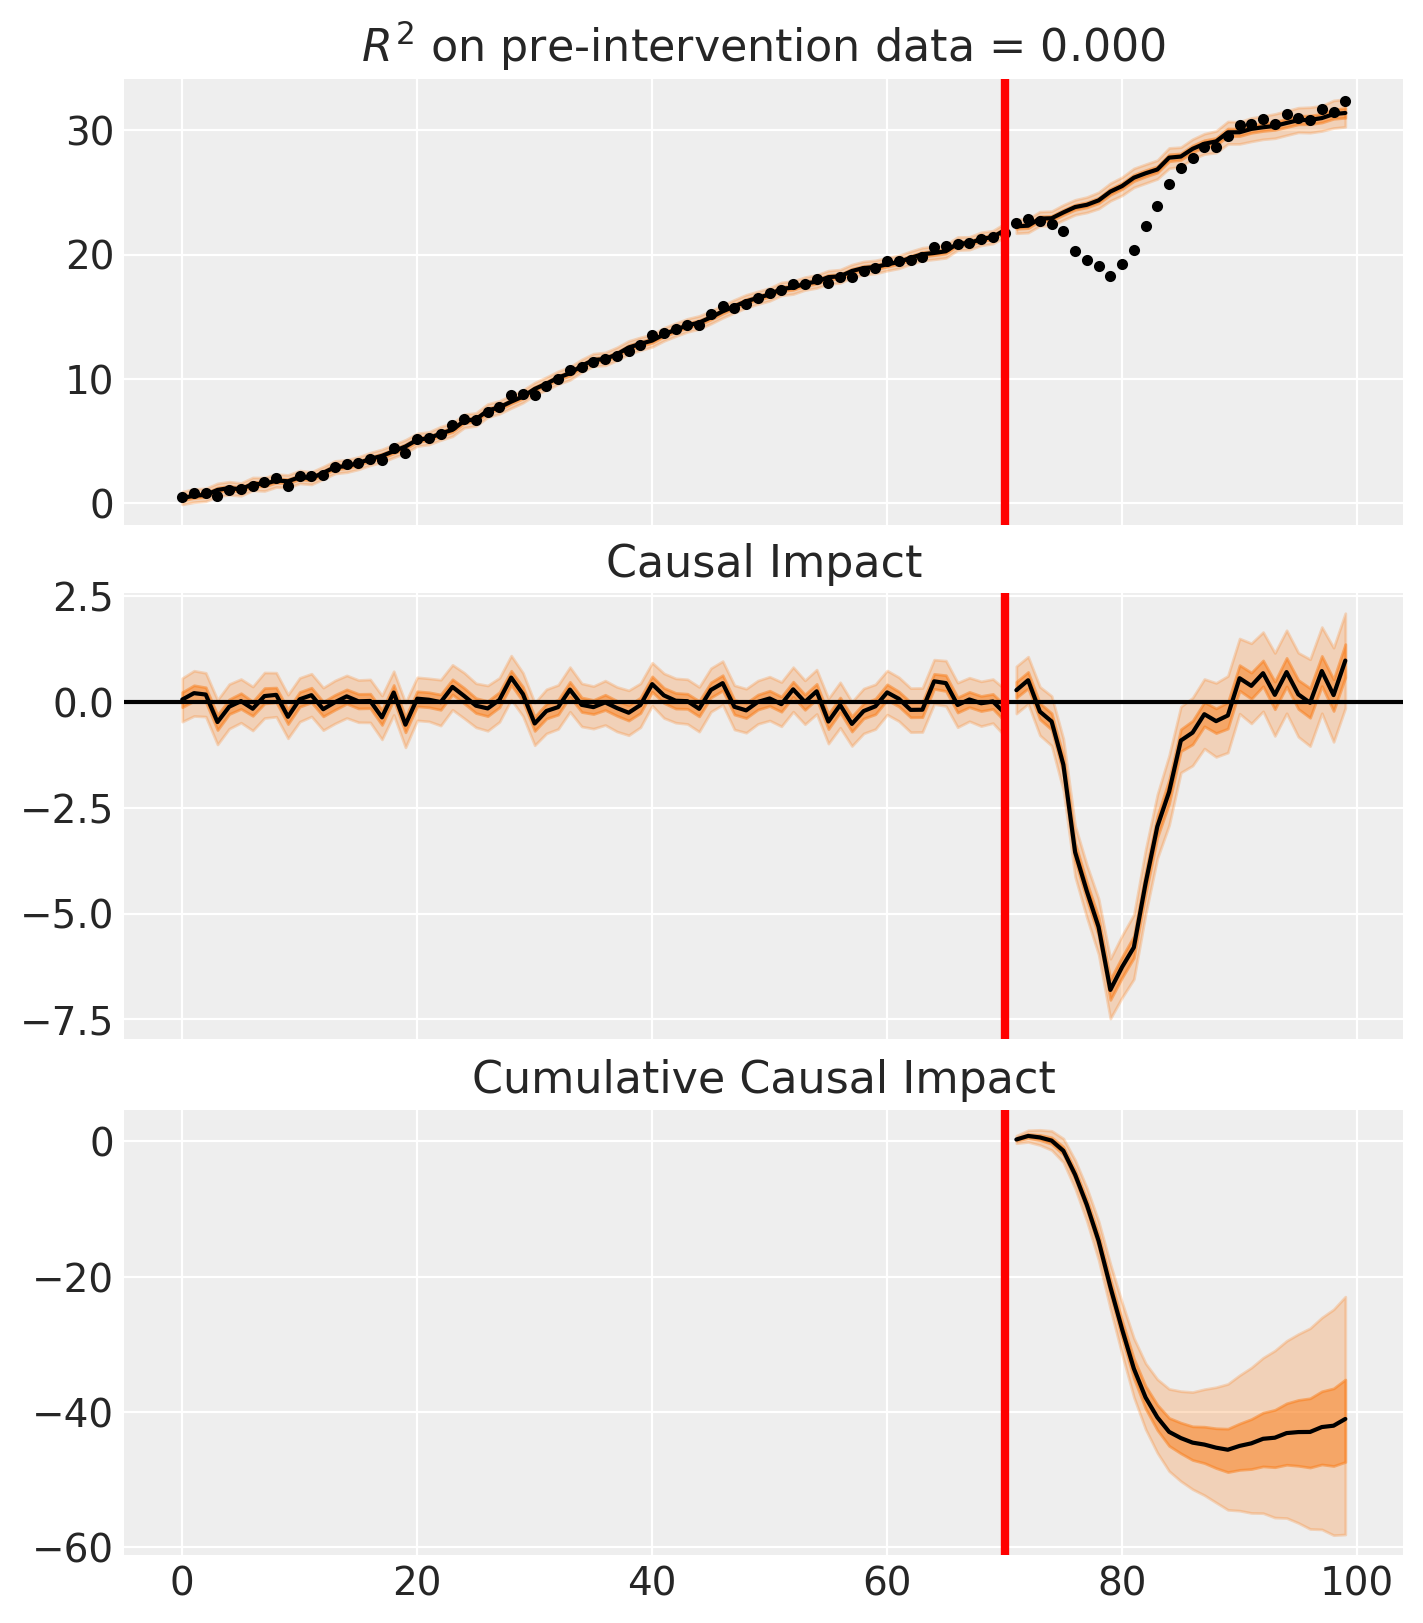

In [6]:
from causalpy.pymc_experiments import SyntheticControl
from causalpy.pymc_models import WeightedSumFitter

# Note, we do not want an intercept in this model
thing = SyntheticControl(data,
                         treatment_time,
                         formula = "actual ~ 0 + a + b + c + d + e + f + g",
                         prediction_model=WeightedSumFitter())

thing.plot();

if export_images:
    plt.savefig('../img/synthetic_control_pymc.svg', bbox_inches='tight', format="svg")

## Interrupted time series

In [7]:
# # Generate data
# from causalpy.simulate_data import generate_time_series_data

# df = generate_time_series_data("2017-01-01")
# df = df.loc[:, ['month', 'year', 't', 'y']]
# df.to_csv("../causalpy/data/its.csv")

In [8]:
# Load data
df = pd.read_csv('../causalpy/data/its.csv', parse_dates=["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


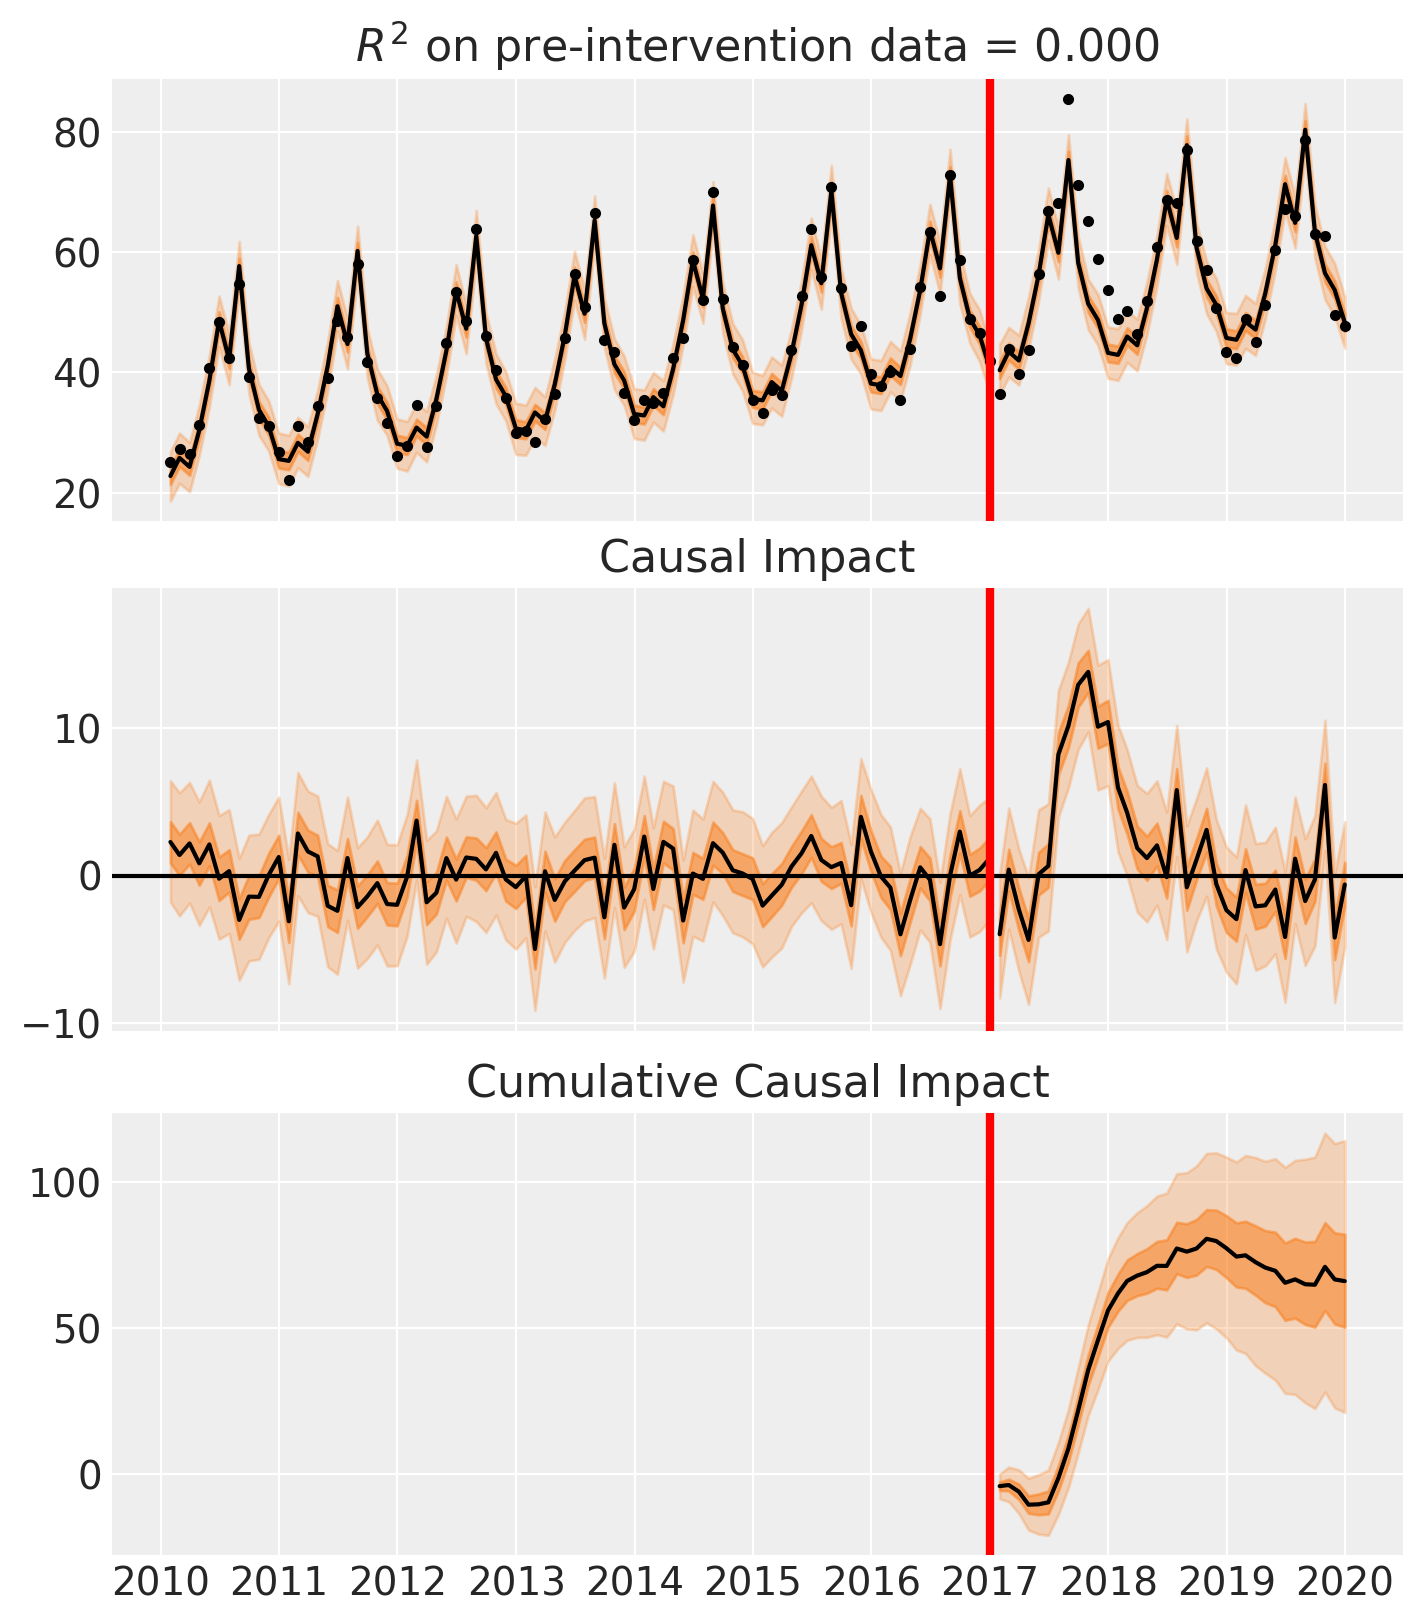

In [9]:
from causalpy.pymc_experiments import InterruptedTimeSeries
from causalpy.pymc_models import LinearRegression

thing = InterruptedTimeSeries(df, 
                              treatment_time, 
                              formula = 'y ~ 1 + t + C(month)', 
                              prediction_model=LinearRegression())

fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/interrupted_time_series_pymc.svg', bbox_inches='tight', format="svg")

## Difference in differences

In [19]:
data = pd.read_csv("../causalpy/data/did.csv")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8873, but should be close to 0.8. Try to increase the number of tuning steps.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


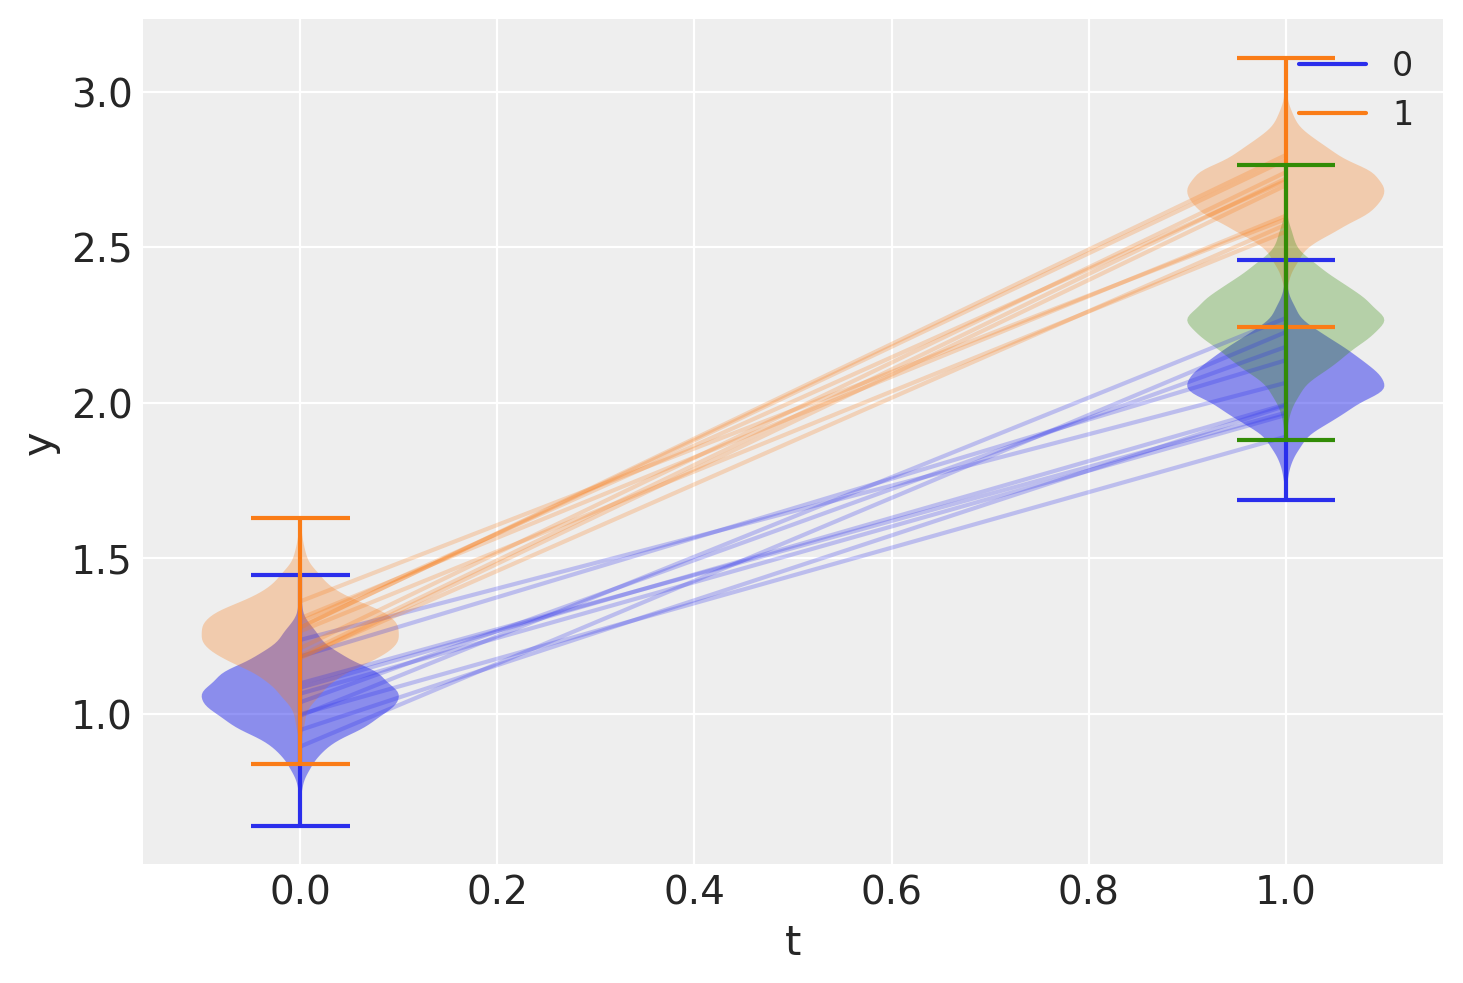

In [57]:
from causalpy.pymc_experiments import DifferenceInDifferences
from causalpy.pymc_models import LinearRegression

# NOTE: `treated` is a deterministic function of `t` and `group`. So add this function into the formula.

thing = DifferenceInDifferences(data, 
                                formula = 'y ~ 1 + group + t + treated:group',
                                prediction_model=LinearRegression())
fig, ax = thing.plot()

if export_images:
    plt.savefig('../img/difference_in_differences_pymc.svg', bbox_inches='tight', format="svg")

## Regression discontinuity

In [10]:
# # Generate data
# from causalpy.simulate_data import generate_regression_discontinuity_data
# df = generate_regression_discontinuity_data(true_treatment_threshold=0.5)
# df.to_csv('../causalpy/data/regression_discontinuity.csv', index=False)

In [11]:
# Load data
data = pd.read_csv('../causalpy/data/regression_discontinuity.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


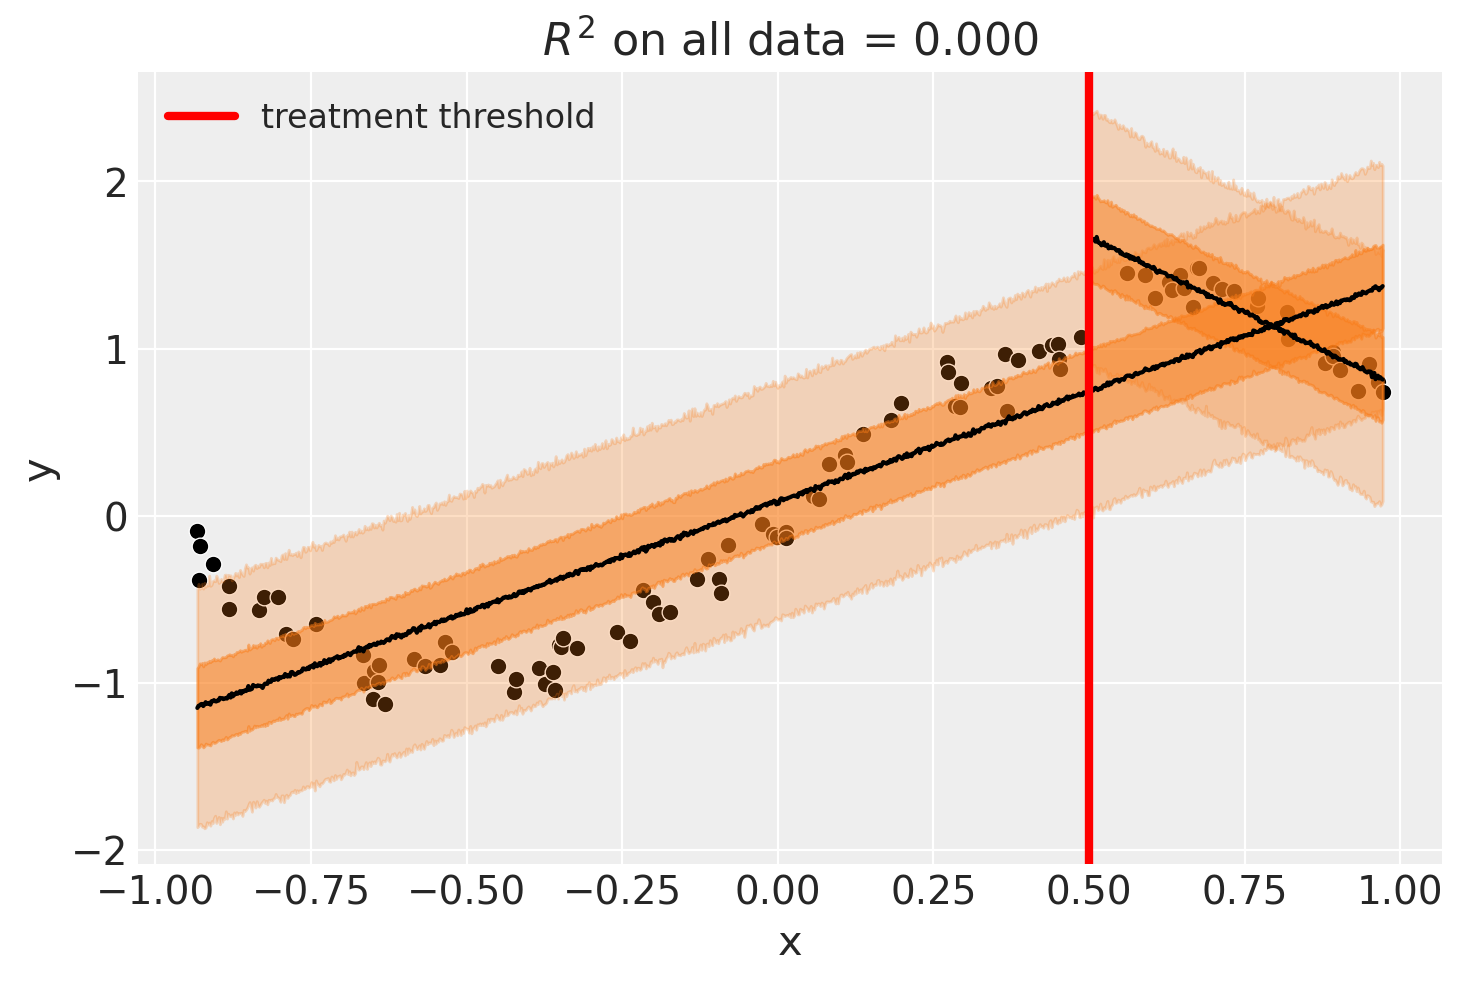

In [12]:
from causalpy.pymc_experiments import RegressionDiscontinuity
from causalpy.pymc_models import LinearRegression

thing = RegressionDiscontinuity(data, 
                                formula = 'y ~ 1 + x + treated + x:treated',
                                prediction_model=LinearRegression(), 
                                treatment_threshold=0.5)
thing.plot()

if export_images:
    plt.savefig('../img/regression_discontinuity_pymc.svg', bbox_inches='tight', format="svg")

TODO: apply GP model OR use non-linear features (i.e. polynomial or sin basis functions) in linear regression approach